 # WormBase INDRA Statements to IndraNet Interaction Networks

**Bradley Buchner**

The code below uses IndraNet and IndraNetAssembler to process INDRA Statements from WormBase and turn them into networkx graphs. Two networks are created: one for all INDRA statements (a.k.a the full network), and one for only INDRA statements for aging-related interactions, (a.k.a. the aging network).


## Findings and Decisions
(1) The genetic and molecular interactions files from WormBase actually does contain the same interaction more than once, but each duplicate is listed under its own unique WB interaction ID, meaning that some edges in the interaction network correspond to multiple INDRA statements. In the network, I define an interaction's 'evidence' as the number of INDRA statements associated with it.

(2) For some agent pairs in the network, there are not only multiple INDRA statements associated with it but also multiple interaction types. E.g., the subject-object pair tbx-8 and tbx-9 is associated with interaction types IncreaseAmount, DecreaseAmount, and Complex. To handle this, I decided to hold onto only the interaction type with the most recent discovery date. If there's a tie, I choose an interaction type at random.

(3) Complex interactions are double-counted, so there are two edges between agents in every Complex interaction. The make_df() method does this by design– I'm not sure the purpose of it, but I chose to leave this setting as is.

(4) Some interactions are duplicated with alternate agent IDs. E.g., the Complex interation between tbx-8 and tbx-9 is counted twice, with the only difference being that one uses the Uniprot (UP) ID for tbx-9 (in the column 'agB_id') and the other uses an alternate ID. To handle this, I decided to keep only the interaction with the most recent discovery date for these special cases, which totaled only 126 out of 72,712 total agent pairs.

(5) There are 574 Complex interactions of an agent with itself, which create self loops in the network.


In [1]:
import sys
import requests
sys.path.append('/Users/bradleybuchner/Desktop/Grad School/Research/Aging Project/indra/indra')
from sources.wormbase import *
from indra.assemblers.indranet import IndraNetAssembler
from indra.assemblers.indranet import IndraNet
import networkx as nx
import json
import numpy as np

# full_file_gen = '/Users/bradleybuchner/Desktop/Grad School/Research/Aging Project/data/INTERACTION-GEN_WB.tsv'
# full_file_mol = '/Users/bradleybuchner/Desktop/Grad School/Research/Aging Project/data/INTERACTION-MOL_WB_3.tsv'
# full_file_map = '/Users/bradleybuchner/Desktop/Grad School/Research/Aging Project/data/wormbase_entrez_mappings.tsv'

In [2]:
processor = process_from_web()
# processor = process_from_files(full_file_gen, full_file_mol, full_file_map)
all_statements = processor.statements

Processing WormBase rows: 100%|██████████| 97382/97382 [01:18<00:00, 1248.39it/s]


## Statement List Processing

In [33]:
## Summarize statement list and filter out duplicates
from collections import Counter
print(f'Number of statements before filtering: {len(all_statements)}')
str_stmts = [str(stmt) for stmt in all_statements]
stmt_counter = Counter(str_stmts)
more_than_one_stmts = {key: value for key, value in stmt_counter.items() if value > 1}
print(f'\nNumber of statements with more than one occurence: {len(more_than_one_stmts.keys())}')

# Iterate in reverse order to keep the last occurrence of each duplicate since the statement list is in chronological order of discovery date, and we want to keep the most recent duplicate.
seen_statements = set()
filtered_stmt_list = []
for s in reversed(all_statements):
    str_stmt = str(s)
    if str_stmt not in seen_statements:
        seen_statements.add(str_stmt)
        filtered_stmt_list.append(s)

# Reverse the list back to maintain original order
filtered_stmt_list.reverse()
print(f'\nNumber of statements after filtering: {len(filtered_stmt_list)}')
# print(f'\nUnique statement counts after filtering: {Counter(filtered_stmt_list).most_common(5)}\n')

agents_to_int_types = {str(s.real_agent_list()): [] for s in filtered_stmt_list}
for s in filtered_stmt_list:
    agents = str(s.real_agent_list())
    agents_to_int_types[agents].append(type(s).__name__)

count = 0
total_count = 0
for agent_pair in agents_to_int_types:
    total_count += 1
    if len(agents_to_int_types.get(agent_pair)) > 1:
        count += 1
        # print(f'{agent_pair}: {agents_to_int_types.get(agent_pair)}')

print(f'\nNumber of agent pairs with more than one interaction type: {count} (out of {total_count} total agent pairs)')

Number of statements before filtering: 90386

Number of statements with more than one occurence: 7853

Number of statements after filtering: 72856

Number of agent pairs with more than one interaction type: 126 (out of 72724 total agent pairs)


In [12]:
## Create an interaction DataFrame with two extra columns using the make_df() method and print its number of rows
def get_evidence_count_custom(stmt):
    str_stmt = str(stmt)
    occurences = stmt_counter.get(str_stmt)
    return int(occurences)

import re
def get_year(stmt):
    interaction_info = stmt.evidence[0].annotations.get('interaction_info', {})
    pub_authors_str = interaction_info.get('publication_first_authors')

    if not isinstance(pub_authors_str, str):  # Ensure it's a string
        return 0

    match = re.search(r'\((\d{4})\)', pub_authors_str)  # Extracts 4-digit year
    return int(match.group(1)) if match else 0

worm_net_assembler_full = IndraNetAssembler(filtered_stmt_list)

worm_network_df_full = worm_net_assembler_full.make_df(keep_self_loops=True, extra_columns=[('evidence_count_custom', get_evidence_count_custom), ('discovery_year', get_year)])

worm_network_basic_df_full = worm_net_assembler_full.make_df(keep_self_loops=False, extra_columns=[('evidence_count_custom', get_evidence_count_custom), ('discovery_year', get_year)])

# Add a log-normalized confidence column
max_evidence = worm_network_df_full['evidence_count_custom'].max()
worm_network_df_full['interaction_confidence'] = (
    np.log1p(worm_network_df_full['evidence_count_custom']) /
    np.log1p(max_evidence)
)
max_evidence_basic = worm_network_basic_df_full['evidence_count_custom'].max()
worm_network_basic_df_full['interaction_confidence'] = (
    np.log1p(worm_network_basic_df_full['evidence_count_custom']) /
    np.log1p(max_evidence_basic)
)

print(f'\nNumber of rows in network df: {worm_network_df_full.shape[0]}')
print(f'\nNumber of rows in basic network df: {worm_network_basic_df_full.shape[0]}')


Number of rows in network df: 142604

Number of rows in basic network df: 141454


In [13]:
## Inspect an example in the DataFrame of an agent pair having more than one type of interaction AND duplicated rows of the same interaction type (tbx-8 and tbx-9)
display(worm_network_df_full[(worm_network_df_full.agA_name == 'tbx-8') & (worm_network_df_full.agB_name == 'tbx-9')])
# display(worm_network_df_full[(worm_network_df_full.agA_name == 'daf-16') & (worm_network_df_full.agB_name == 'akt-1')])


,agA_name,agB_name,agA_ns,agA_id,agB_ns,agB_id,residue,position,stmt_type,evidence_count,stmt_hash,belief,source_counts,initial_sign,evidence_count_custom,discovery_year,interaction_confidence
1059,tbx-8,tbx-9,UP,Q22292,UP,Q22289,None,None,IncreaseAmount,1,18814132200930594,1,{'wormbase': 1},None,1,2004,0.136915
2532,tbx-8,tbx-9,UP,Q22292,UP,Q22289,None,None,DecreaseAmount,1,-2215717740639521,1,{'wormbase': 1},None,1,2011,0.136915
17874,tbx-8,tbx-9,UP,Q22292,UP,Q22289,None,None,Complex,1,34504847081181691,1,{'wormbase': 1},None,2,2013,0.217006
122666,tbx-8,tbx-9,UP,Q22292,TEXT,tbx-9,None,None,Complex,1,1815207662176294,1,{'wormbase': 1},None,1,2016,0.136915


In [14]:
## Show how Complex interactions are counted twice in the network since and are given two edges:

statement_type_counter_og = Counter([type(s).__name__ for s in filtered_stmt_list])
print(f'Interaction type counts from list of INDRA statements: \n\t{statement_type_counter_og}')

statement_type_counter_df = Counter(worm_network_df_full['stmt_type'])
print(f'\nInteraction type counts from IndraNet DataFrame: \n\t{statement_type_counter_df}')

Interaction type counts from list of INDRA statements: 
	Counter({'Complex': 69748, 'DecreaseAmount': 2114, 'IncreaseAmount': 988, 'Phosphorylation': 3, 'Demethylation': 2, 'Methylation': 1})

Interaction type counts from IndraNet DataFrame: 
	Counter({'Complex': 139496, 'DecreaseAmount': 2114, 'IncreaseAmount': 988, 'Phosphorylation': 3, 'Demethylation': 2, 'Methylation': 1})


In [15]:
## Show the number of self interactions in the statement list
from itertools import permutations
edge_count = 0
self_loop_count = 0
for s in filtered_stmt_list:
    if type(s).__name__ == "Complex":
        not_none_agents = s.real_agent_list()
        if len(not_none_agents) > 1:
            edges = [(a, b, None) for a, b in
                             permutations(not_none_agents, 2)]
            edge_count += len(edges)
        for (agA, agB, sign) in edges:
            if agA.name == agB.name:
                self_loop_count += 1

print(f'Number of self loops (self interactions): {int(self_loop_count/2)} (out of {int(edge_count/2)} total interactions)')

Number of self loops (self interactions): 575 (out of 69748 total interactions)


In [16]:
## Filter df to address agent pair-interaction type combinations that are getting double-counted due to alternate agent IDs. E.g., the Complex interaction between tbx-8 and tbx-9 is counted twice, with the only difference being one uses the Uniprot (UP) ID for tbx-9 and the other uses an alternate ID. For each combination, keep only the one with the most recent 'discovery_year'.
filtered_worm_network_df_full = worm_network_df_full.sort_values(
    'discovery_year',
    ascending=False
).drop_duplicates(
    subset=['agA_name', 'agB_name'],
    keep='first'
).reset_index(drop=True)

print(f'Rows in filtered df: {filtered_worm_network_df_full.shape[0]}')

## Inspect an example agent pair in the DataFrame
display(filtered_worm_network_df_full[(filtered_worm_network_df_full.agA_name == 'daf-16') & (filtered_worm_network_df_full.agB_name == 'akt-1')])


Rows in filtered df: 138749


,agA_name,agB_name,agA_ns,agA_id,agB_ns,agB_id,residue,position,stmt_type,evidence_count,stmt_hash,belief,source_counts,initial_sign,evidence_count_custom,discovery_year,interaction_confidence
47780,daf-16,akt-1,UP,O16850,UP,Q17941,None,None,Complex,1,-2653545217314764,1,{'wormbase': 1},None,3,2004,0.273831
1165,daf-16,akt-1,UP,O16850,UP,Q17941,None,None,DecreaseAmount,1,-35140614671118626,1,{'wormbase': 1},None,1,2006,0.136915


In [17]:
## Filter df to address agent pair-interaction type combinations that are getting double-counted due to either multiple interaction types or alternate agent IDs. For each combination, keep only the one with the highest 'interaction_confidence', or most recent 'discovery_year' for ties.
filtered_worm_network_basic_df_full = worm_network_basic_df_full.sort_values(
    ['interaction_confidence', 'discovery_year'],
    ascending=[False, False]
).drop_duplicates(
    subset=['agA_name', 'agB_name'],
    keep='first'
).reset_index(drop=True)

print(f'Rows in filtered df: {filtered_worm_network_basic_df_full.shape[0]}')

## Inspect an example agent pair in the DataFrame
display(filtered_worm_network_basic_df_full[(filtered_worm_network_basic_df_full.agA_name == 'daf-16') & (filtered_worm_network_basic_df_full.agB_name == 'akt-1')])


Rows in filtered df: 137964


,agA_name,agB_name,agA_ns,agA_id,agB_ns,agB_id,residue,position,stmt_type,evidence_count,stmt_hash,belief,source_counts,initial_sign,evidence_count_custom,discovery_year,interaction_confidence
3820,daf-16,akt-1,UP,O16850,UP,Q17941,None,None,Complex,1,-2653545217314764,1,{'wormbase': 1},None,3,2004,0.273831


# Create the Full Network

### Full Network (with self loops and contradictory interactions included)

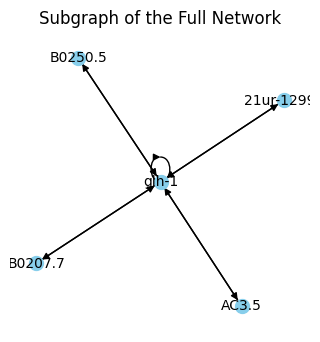

Number of nodes: 10987
Number of edges: 138749
Edge attributes:

Edge (B0207.7, glh-1) has attributes: {'statements': [{'stmt_hash': -28053090247285571, 'stmt_type': 'Complex', 'evidence_count': 1, 'belief': 1, 'source_counts': {'wormbase': 1}, 'residue': None, 'initial_sign': None, 'discovery_year': 2022, 'interaction_confidence': 0.13691539142239212, 'evidence_count_custom': 1, 'position': None}], 'sign': 0, 'belief': 1.0}

Edge (glh-1, B0207.7) has attributes: {'statements': [{'stmt_hash': -28053090247285571, 'stmt_type': 'Complex', 'evidence_count': 1, 'belief': 1, 'source_counts': {'wormbase': 1}, 'residue': None, 'initial_sign': None, 'discovery_year': 2022, 'interaction_confidence': 0.13691539142239212, 'evidence_count_custom': 1, 'position': None}], 'sign': 0, 'belief': 1.0}

Edge (glh-1, glh-1) has attributes: {'statements': [{'stmt_hash': -30547541227696274, 'stmt_type': 'Complex', 'evidence_count': 1, 'belief': 1, 'source_counts': {'wormbase': 1}, 'residue': None, 'initial_s

In [23]:
## Create the aging network, plot a subgraph of it, and print its number of edges, nodes, and examples of edge attributes
def flattening_function(G, edge):
    # Return the average belief score of the constituent edges
    all_beliefs = [s['belief'] for s in G.edges[edge]['statements']]
    return sum(all_beliefs)/len(all_beliefs)

sign_dict = {'Complex': 0, 'IncreaseAmount': 1, 'DecreaseAmount': -1, 'Phosphorylation': 0, 'Demethylation': 0, 'Methylation': 0}

worm_network_full_signed = IndraNet().signed_from_df(df=filtered_worm_network_df_full, sign_dict=sign_dict, flattening_method=flattening_function)

nodes_to_plot = list(worm_network_full_signed.nodes())[:5]
subgraph = worm_network_full_signed.subgraph(nodes_to_plot)
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
nx.draw(subgraph, with_labels=True, node_size=100, node_color='skyblue', font_size=10)
plt.title('Subgraph of the Full Network')
plt.show()

print(f'Number of nodes: {worm_network_full_signed.number_of_nodes()}')
print(f'Number of edges: {worm_network_full_signed.number_of_edges()}')

print("Edge attributes:\n")
for u, v, data in subgraph.edges(data=True):
    print(f"Edge ({u}, {v}) has attributes: {data}\n")


In [28]:
## Convert the networkx graph to a JSON-serializable format
full_graph_data = nx.node_link_data(worm_network_full_signed)
with open('data/worm_network_full_signed.json', 'w') as f:
    json.dump(full_graph_data, f, indent=4)

/Users/bradleybuchner/Desktop/Grad School/Research/Aging Project/worm_lifespan/.venv/lib/python3.11/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


### Full Network (without self loops and contradictory interactions included)

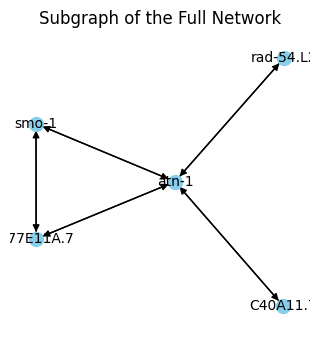

Number of nodes: 10965
Number of edges: 137964
Edge attributes:

Edge (rad-54.L2, atn-1) has attributes: {'statements': [{'stmt_hash': 5052633785247066, 'stmt_type': 'Complex', 'evidence_count': 1, 'belief': 1, 'source_counts': {'wormbase': 1}, 'residue': None, 'initial_sign': None, 'discovery_year': 2004, 'interaction_confidence': 1.0, 'evidence_count_custom': 157, 'position': None}], 'sign': 0, 'belief': 1.0}

Edge (Y77E11A.7, atn-1) has attributes: {'statements': [{'stmt_hash': -4432179866214290, 'stmt_type': 'Complex', 'evidence_count': 1, 'belief': 1, 'source_counts': {'wormbase': 1}, 'residue': None, 'initial_sign': None, 'discovery_year': 2004, 'interaction_confidence': 0.5917384768109366, 'evidence_count_custom': 19, 'position': None}], 'sign': 0, 'belief': 1.0}

Edge (Y77E11A.7, smo-1) has attributes: {'statements': [{'stmt_hash': -4224397468368858, 'stmt_type': 'Complex', 'evidence_count': 1, 'belief': 1, 'source_counts': {'wormbase': 1}, 'residue': None, 'initial_sign': None

In [25]:
## Create the aging network, plot a subgraph of it, and print its number of edges, nodes, and examples of edge attributes
def flattening_function(G, edge):
    # Return the average belief score of the constituent edges
    all_beliefs = [s['belief'] for s in G.edges[edge]['statements']]
    return sum(all_beliefs)/len(all_beliefs)

sign_dict = {'Complex': 0, 'IncreaseAmount': 1, 'DecreaseAmount': -1, 'Phosphorylation': 0, 'Demethylation': 0, 'Methylation': 0}

worm_network_basic_full_signed = IndraNet().signed_from_df(df=filtered_worm_network_basic_df_full, sign_dict=sign_dict, flattening_method=flattening_function)

nodes_to_plot = list(worm_network_basic_full_signed.nodes())[:5]
subgraph = worm_network_basic_full_signed.subgraph(nodes_to_plot)
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
nx.draw(subgraph, with_labels=True, node_size=100, node_color='skyblue', font_size=10)
plt.title('Subgraph of the Full Network')
plt.show()

print(f'Number of nodes: {worm_network_basic_full_signed.number_of_nodes()}')
print(f'Number of edges: {worm_network_basic_full_signed.number_of_edges()}')

print("Edge attributes:\n")
for u, v, data in subgraph.edges(data=True):
    print(f"Edge ({u}, {v}) has attributes: {data}\n")


In [27]:
import os
os.getcwd()

'/Users/bradleybuchner/Desktop/Grad School/Research/Aging Project/worm_lifespan/worm_lifespan'

In [30]:
## Convert the networkx graph to a JSON-serializable format
full_basic_graph_data = nx.node_link_data(worm_network_basic_full_signed)
with open('data/worm_network_basic_full_signed.json', 'w') as f:
    json.dump(full_basic_graph_data, f, indent=4)

/Users/bradleybuchner/Desktop/Grad School/Research/Aging Project/worm_lifespan/.venv/lib/python3.11/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


# Create the Aging Network

In [34]:
def get_mesh_ids_for_pmids(pmid_list):
    """Function that uses INDRA api to get all MeSH IDs for a list of PMIDs

    Parameters
    ----------
    pmid_list : list
        List of PMIDs

    Returns
    -------
    pmid_mesh_dict : dict
        Dictionary of pmid:[mesh ids] pairs
    """
    url = "https://discovery.indra.bio/api/get_mesh_ids_for_pmids"
    payload = {
      "pmids": pmid_list
    }
    response = requests.post(url, json=payload)
    if response.status_code == 200:
        pmid_mesh_dict = response.json()
        return pmid_mesh_dict
    else:
        print("Error:", response.status_code, response.text)

def map_mesh_ids_to_terms(mesh_ids):
    """Function that uses NIH api to map MeSH IDs to MeSH terms

    Parameters
    ----------
    mesh_ids : list
        List of MeSH IDs

    Returns
    -------
    results : dict
        Dictionary of id:term mappings
    """
    base_url = "https://id.nlm.nih.gov/mesh/"
    results = {}
    for mesh_id in mesh_ids:
        url = f"{base_url}{mesh_id}.json"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            mesh_term = data.get('label', 'Unknown Term').get('@value')
            results[mesh_id] = mesh_term
        else:
            results[mesh_id] = f"Error: {response.status_code}"
    return results

In [35]:
# Create PMID-to-MeSH IDs dictionary
all_pmids = [s.evidence[0].pmid for s in filtered_stmt_list]
pmid_meshid_dict = get_mesh_ids_for_pmids(all_pmids)
all_mesh_ids = []
for pmid in pmid_meshid_dict:
    all_mesh_ids.extend(pmid_meshid_dict.get(pmid))
unique_mesh_ids = list(set(all_mesh_ids))

# Create MeSH ID-to-Term dictionary
mesh_id_to_term_dict = map_mesh_ids_to_terms(unique_mesh_ids)

In [61]:
## Add MeSH terms into statement evidences (annotations)
for s in all_statements:
    if pmid_meshid_dict.get(s.evidence[0].pmid):
        s.evidence[0].annotations['mesh_terms'] = {mesh_id: mesh_id_to_term_dict.get(mesh_id) for mesh_id in pmid_meshid_dict.get(s.evidence[0].pmid)}
    else:
        s.evidence[0].annotations['mesh_terms'] = {}


In [62]:
aging_mesh_terms = ['Aging', 'Cellular Senescence', 'Erythrocyte Aging', 'Senescence-Associated Secretory Phenotype', 'Telomere Shortening', 'Cognitive Aging', 'Immunosenescence', 'T-Cell Senescence', 'Longevity']

from collections import Counter
aging_str_stmts = [str(s) for s in all_statements if any([term in s.evidence[0].annotations['mesh_terms'].values() for term in aging_mesh_terms])]
aging_str_stmt_counter = Counter(aging_str_stmts)
aging_more_than_one_stmts = {key: value for key, value in aging_str_stmt_counter.items() if value > 1}
print(f'\nNumber of aging-related statements with more than one occurrence: {len(aging_more_than_one_stmts.keys())}')


Number of aging-related statements with more than one occurrence: 167


In [63]:
## Show the number of INDRA statements whose PubMed ID contains an Aging-related MeSH term
aging_statements = [s for s in filtered_stmt_list if any([term in s.evidence[0].annotations['mesh_terms'].values() for term in aging_mesh_terms])]

print(f"Number of statements with an Aging-related MeSH term: {len(aging_statements)} (out of {len(filtered_stmt_list)} total statements)")

Number of statements with an Aging-related MeSH term: 4345 (out of 72856 total statements)


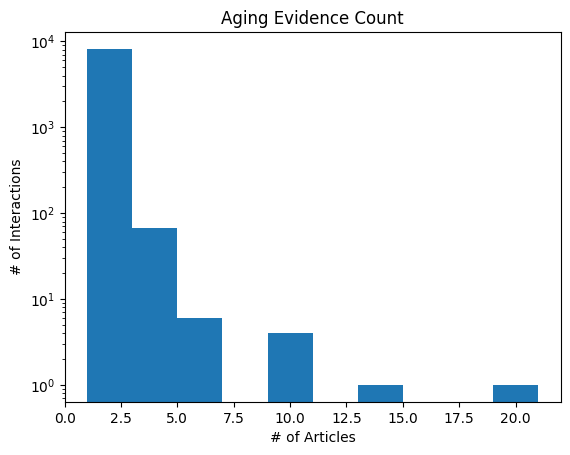

In [80]:
## Create an interaction DataFrame with two extra columns for aging-related statements using the make_df() method, print its number of rows and its interaction type counts
def get_aging_evidence_count_custom(stmt):
    str_stmt = str(stmt)
    occurences = aging_str_stmt_counter.get(str_stmt)
    return int(occurences)

worm_net_assembler_aging = IndraNetAssembler(aging_statements)
worm_network_df_aging = worm_net_assembler_aging.make_df(keep_self_loops=False, extra_columns=[('evidence_count_custom', get_evidence_count_custom), ('aging_evidence_count', get_aging_evidence_count_custom), ('discovery_year', get_year)])

# Add a log-normalized confidence column for evidence_count_custom
max_evidence_count_custom = worm_network_df_aging['evidence_count_custom'].max()
worm_network_df_aging['interaction_confidence'] = (
    np.log1p(worm_network_df_aging['evidence_count_custom']) /
    np.log1p(max_evidence_count_custom)
)

# Add a log-normalized confidence column for aging_evidence_count
max_aging_evidence_count = worm_network_df_aging['aging_evidence_count'].max()
worm_network_df_aging['phenotype_confidence'] = (
    np.log1p(worm_network_df_aging['aging_evidence_count']) /
    np.log1p(max_aging_evidence_count)
)

plt.figure(figsize=(4,4))
plt.hist(worm_network_df_aging['aging_evidence_count'])
plt.yscale('log')
plt.xlabel('# of Articles')
plt.ylabel('# of Interactions')
plt.title('Aging Evidence Count')
plt.show()

In [69]:
## Filter df to address agent pair-interaction type combinations that are getting double-counted due to either multiple interaction types or alternate agent IDs. For each combination, keep only the one with the highest 'interaction_confidence', or most recent 'discovery_year' for ties.
print(f'Rows in original df: {worm_network_df_aging.shape[0]}')

filtered_worm_network_df_aging = worm_network_df_aging.sort_values(
    ['interaction_confidence', 'discovery_year'],
    ascending=[False, False]
).drop_duplicates(
    subset=['agA_name', 'agB_name'],
    keep='first'
).reset_index(drop=True)

print(f'Rows in filtered df: {filtered_worm_network_df_aging.shape[0]}')

Rows in original df: 8266
Rows in filtered df: 8234


In [81]:
phenotype_confidence_dict = {}
for i in range(filtered_worm_network_df_aging.shape[0]):
    agent_a = filtered_worm_network_df_aging.iloc[i]['agA_name']
    agent_b = filtered_worm_network_df_aging.iloc[i]['agB_name']
    confidence = filtered_worm_network_df_aging.iloc[i]['phenotype_confidence']
    if agent_a not in phenotype_confidence_dict:
        phenotype_confidence_dict[agent_a] = float(confidence)
    if agent_b not in phenotype_confidence_dict:
        phenotype_confidence_dict[agent_b] = float(confidence)

for i in range(filtered_worm_network_df_full.shape[0]):
    agent_a = filtered_worm_network_df_full.iloc[i]['agA_name']
    agent_b = filtered_worm_network_df_full.iloc[i]['agB_name']
    confidence = 0
    if agent_a not in phenotype_confidence_dict:
        phenotype_confidence_dict[agent_a] = float(confidence)
    if agent_b not in phenotype_confidence_dict:
        phenotype_confidence_dict[agent_b] = float(confidence)

# print(phenotype_confidence_dict.keys())
# print(Counter(phenotype_confidence_dict.values()))
# print(len(phenotype_confidence_dict.keys()))

import pickle

with open('data/phenotype_confidence_dict.pkl', 'wb') as f:
    pickle.dump(phenotype_confidence_dict, f)

# with open('phenotype_confidence_dict.pkl', 'rb') as f:
#     loaded = pickle.load(f)

### Aging Network (with self loops and all contradictory interactions included)

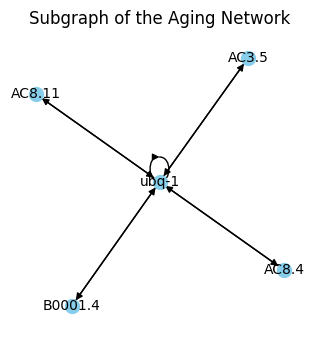

Number of nodes: 2951
Number of edges: 8246
Edge attributes:

Edge (ubq-1, ubq-1) has attributes: {'statements': [{'stmt_hash': 27707448942197684, 'stmt_type': 'Complex', 'evidence_count': 1, 'belief': 1, 'source_counts': {'wormbase': 1}, 'residue': None, 'position': None, 'initial_sign': None, 'discovery_year': 2021}], 'sign': 0, 'belief': 1.0}

Edge (ubq-1, AC8.4) has attributes: {'statements': [{'stmt_hash': 19973094656955107, 'stmt_type': 'Complex', 'evidence_count': 1, 'belief': 1, 'source_counts': {'wormbase': 1}, 'residue': None, 'position': None, 'initial_sign': None, 'discovery_year': 2021}], 'sign': 0, 'belief': 1.0}

Edge (ubq-1, B0001.4) has attributes: {'statements': [{'stmt_hash': -8702614086499404, 'stmt_type': 'Complex', 'evidence_count': 1, 'belief': 1, 'source_counts': {'wormbase': 1}, 'residue': None, 'position': None, 'initial_sign': None, 'discovery_year': 2021}], 'sign': 0, 'belief': 1.0}

Edge (ubq-1, AC8.11) has attributes: {'statements': [{'stmt_hash': -3052495

In [354]:
## Create the aging network, plot a subgraph of it, and print its number of edges, nodes, and examples of edge attributes
def flattening_function(G, edge):
    # Return the average belief score of the constituent edges
    all_beliefs = [s['belief'] for s in G.edges[edge]['statements']]
    return sum(all_beliefs)/len(all_beliefs)

sign_dict = {'Complex': 0, 'IncreaseAmount': 1, 'DecreaseAmount': -1, 'Phosphorylation': 0, 'Demethylation': 0, 'Methylation': 0}

worm_network_aging_signed = IndraNet().signed_from_df(df=filtered_worm_network_df_aging, sign_dict=sign_dict, flattening_method=flattening_function)

nodes_to_plot = list(worm_network_aging_signed.nodes())[:5]
subgraph = worm_network_aging_signed.subgraph(nodes_to_plot)
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
nx.draw(subgraph, with_labels=True, node_size=100, node_color='skyblue', font_size=10)
plt.title('Subgraph of the Aging Network')
plt.show()

print(f'Number of nodes: {worm_network_aging_signed.number_of_nodes()}')
print(f'Number of edges: {worm_network_aging_signed.number_of_edges()}')

print("Edge attributes:\n")
for u, v, data in subgraph.edges(data=True):
    print(f"Edge ({u}, {v}) has attributes: {data}\n")

In [341]:
## Convert the networkx graph to a JSON-serializable format
aging_graph_data = nx.node_link_data(worm_network_aging_signed)
with open('data/worm_network_aging_signed.json', 'w') as f:
    json.dump(aging_graph_data, f, indent=4)

/Users/bradleybuchner/Desktop/Grad School/Research/Aging Project/worm_lifespan/.venv/lib/python3.11/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


### Aging Network (without self loops and all contradictory interactions included)

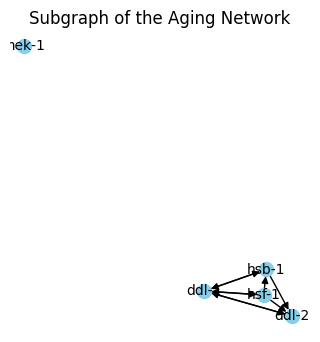

Number of nodes: 2951
Number of edges: 8234
Edge attributes:

Edge (hsf-1, ddl-2) has attributes: {'statements': [{'stmt_hash': 25545491457753874, 'stmt_type': 'DecreaseAmount', 'evidence_count': 1, 'belief': 1, 'source_counts': {'wormbase': 1}, 'residue': None, 'initial_sign': None, 'discovery_year': 2012, 'interaction_confidence': 0.32625951034201905, 'phenotype_confidence': 0.35541805240316376, 'evidence_count_custom': 2, 'position': None}], 'sign': -1, 'belief': 1.0}

Edge (hsf-1, hsb-1) has attributes: {'statements': [{'stmt_hash': 24470350702083479, 'stmt_type': 'DecreaseAmount', 'evidence_count': 1, 'belief': 1, 'source_counts': {'wormbase': 1}, 'residue': None, 'initial_sign': None, 'discovery_year': 2012, 'interaction_confidence': 0.20584683246043445, 'phenotype_confidence': 0.2242438242175754, 'evidence_count_custom': 1, 'position': None}], 'sign': -1, 'belief': 1.0}

Edge (hsf-1, ddl-1) has attributes: {'statements': [{'stmt_hash': -30658433531762854, 'stmt_type': 'Complex',

In [70]:
## Create the aging network, plot a subgraph of it, and print its number of edges, nodes, and examples of edge attributes
def flattening_function(G, edge):
    # Return the average belief score of the constituent edges
    all_beliefs = [s['belief'] for s in G.edges[edge]['statements']]
    return sum(all_beliefs)/len(all_beliefs)

sign_dict = {'Complex': 0, 'IncreaseAmount': 1, 'DecreaseAmount': -1, 'Phosphorylation': 0, 'Demethylation': 0, 'Methylation': 0}

worm_network_basic_aging_signed = IndraNet().signed_from_df(df=filtered_worm_network_df_aging, sign_dict=sign_dict, flattening_method=flattening_function)

nodes_to_plot = list(worm_network_basic_aging_signed.nodes())[:5]
subgraph = worm_network_basic_aging_signed.subgraph(nodes_to_plot)
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
nx.draw(subgraph, with_labels=True, node_size=100, node_color='skyblue', font_size=10)
plt.title('Subgraph of the Aging Network')
plt.show()

print(f'Number of nodes: {worm_network_basic_aging_signed.number_of_nodes()}')
print(f'Number of edges: {worm_network_basic_aging_signed.number_of_edges()}')

print("Edge attributes:\n")
for u, v, data in subgraph.edges(data=True):
    print(f"Edge ({u}, {v}) has attributes: {data}\n")

In [71]:
## Convert the networkx graph to a JSON-serializable format
aging_basic_graph_data = nx.node_link_data(worm_network_basic_aging_signed)
with open('data/worm_network_basic_aging_signed.json', 'w') as f:
    json.dump(aging_basic_graph_data, f, indent=4)

/Users/bradleybuchner/Desktop/Grad School/Research/Aging Project/worm_lifespan/.venv/lib/python3.11/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


In [357]:
# %%capture
import os
wd = os.getcwd()
path = os.path.join(wd, 'worm_indranet.ipynb')
!jupyter nbconvert --to HTML "{path}"

[NbConvertApp] Converting notebook /Users/bradleybuchner/Desktop/Grad School/Research/Aging Project/worm_lifespan/worm_lifespan/worm_indranet.ipynb to HTML
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 393291 bytes to /Users/bradleybuchner/Desktop/Grad School/Research/Aging Project/worm_lifespan/worm_lifespan/worm_indranet.html
